In [2]:
from PIL import Image

from sklearn.metrics import accuracy_score

import random
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
from tqdm import tqdm

import cv2
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torch.optim as optim

# Practica 2
Prats Guasch, Víctor Antonio

## 1. Problema a resoldre
En aquesta segona pràctica es demana crear un xarxa neuronal capaç de discriminar entre gossos i gats. La xarxa desenvolupada s'ha de comparar amb una xarxa ja existent, reentrenada amb el dataset donat. S'ha dedicit implementar també la classificació de les races de les diferents mascotes, a partir de una xarxa estandaritzada.

TODO: Enumerar punts a seguir i estrategia general

## 2. Anàlisi del conjunt de dades
El conjunt de dades proporcionat conté un fitxer anomenat `list.txt` que enumera totes les imatges del dataset, juntament amb seu identificador de "clase" (o raça en el nostre contexte) i la espècie (1: Gat o 2: Gos). Per a treballar amb el dataset, llegirem primer aquest fitxer i crearem un conjunt de entrenament i de test a partir de les imatges enumerades, lo que ens permetrà determinar la categoria objectiu a partir de cadascuna de línies llegides.

In [3]:
dataset_base_path = "../../PetDataset/"
train_percentage = 0.5

def split_train_test(lines):
    random_indices = random.sample(range(len(lines)), int(len(lines) * train_percentage))
    
    random_subset = [lines[i] for i in random_indices]
    remaining_elements = [elem for idx, elem in enumerate(lines) if idx not in random_indices]
    
    return random_subset, remaining_elements
    

with open(f"{dataset_base_path}/annotations/list.txt") as f:
    all_lines = f.readlines()[6:]

train_lines, test_lines = split_train_test(all_lines)

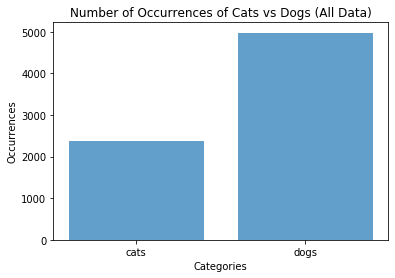

In [4]:
def count_cats_and_dogs(lines) -> dict:
    result = {"cats": 0, "dogs": 0}

    for line in lines:
        if line[0].isupper():
            result["cats"] += 1
        else:
            result["dogs"] += 1
            
    return result
            
base_subset_counts = count_cats_and_dogs(all_lines)
            
plt.bar(base_subset_counts.keys(), base_subset_counts.values(), align='center', alpha=0.7)
plt.xlabel('Categories')
plt.ylabel('Occurrences')
plt.title('Number of Occurrences of Cats vs Dogs (All Data)')
plt.show()

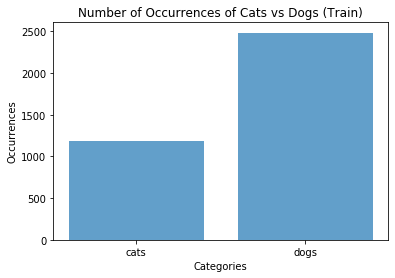

In [4]:
base_subset_counts = count_cats_and_dogs(train_lines)
            
plt.bar(base_subset_counts.keys(), base_subset_counts.values(), align='center', alpha=0.7)
plt.xlabel('Categories')
plt.ylabel('Occurrences')
plt.title('Number of Occurrences of Cats vs Dogs (Train)')
plt.show()

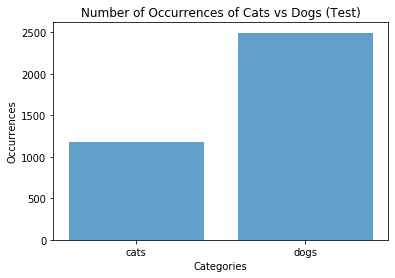

In [5]:
base_subset_counts = count_cats_and_dogs(test_lines)
            
plt.bar(base_subset_counts.keys(), base_subset_counts.values(), align='center', alpha=0.7)
plt.xlabel('Categories')
plt.ylabel('Occurrences')
plt.title('Number of Occurrences of Cats vs Dogs (Test)')
plt.show()

Com podem veure, els conjunts d'entrenament i de proves mantenen el mateix rati d'ocurrencies de gossos i gats. Això podria resultar en el model preferint classificar una imatge donada com a gos enlloc de com a gat, simplement per el nombre d'observacions amb el que ha set entrenat. Podem ara preparar el dataset dividint cada linia per espais i triant la categoria que ens sigui rellevant com a label.

Text(0.5, 1.0, 'Categoria: Dog')

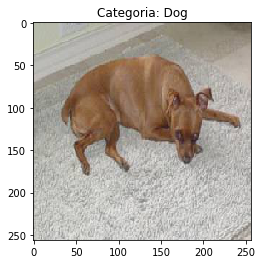

In [6]:
# Seleccionam una linia aleatoria d'entrenament i verificam l'extracció de l'espècie objectiu

species_dict = {2: "Dog", 1: "Cat"}

random.seed(33)
selected_line = train_lines[random.randint(0, len(train_lines))].strip().split(' ')

img = Image.open(f"{dataset_base_path}/images/{selected_line[0]}.jpg")
img = img.convert("RGB")

plt.imshow(img.resize(size = (256, 256)))
plt.title(f"Categoria: {species_dict[int(selected_line[2])]}")

In [5]:
class PetDataset(Dataset):
    def __init__(self, lines, transform=None):
        super().__init__()
        self.lines = lines
        self.len = len(self.lines)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        line = self.lines[index].strip().split(' ')
        image = Image.open(f"{dataset_base_path}/images/{line[0]}.jpg")
        image = image.convert("RGB")
        label = int(line[2])
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label - 1
    
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 256), antialias=True)
    ]
)

train_ds = PetDataset(train_lines, transform)
train_dl = DataLoader(train_ds, batch_size=64)
train_dl.dataset[0][0].shape, train_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 0)

In [6]:
test_ds = PetDataset(test_lines, transform)
test_dl = DataLoader(test_ds, batch_size=64)
test_dl.dataset[0][0].shape, test_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 0)

Una vegada creats els datasets, es definirà una xarxa amb un arquictura similar a la VGG-16 però amb un nombre molt més reduït de capes convolucionals, ja que el problema es molt més reduït.

## Definició de la xarxa

In [9]:
class SmallVGG(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGG, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64x64
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1),
            #nn.Softmax(1)
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x).squeeze()
        return x

In [7]:
class SmallVGGFC(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGGFC, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32x128
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32 * 128, 3072),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(3072, 3072),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(3072, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [8]:
use_cuda = False
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

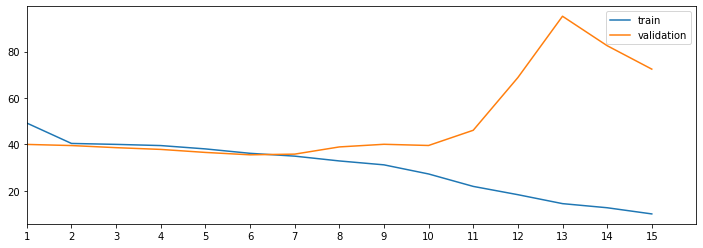

Epoch:15 Training Loss:10.115696045859107 Validation Loss:72.41877429238681: 100%|██████████| 15/15 [2:14:05<00:00, 536.36s/it]


In [9]:
epochs = 15

model = SmallVGGFC(num_classes=2).to(device)

optim = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(reduction="sum")
train_loader = train_dl
val_loader = test_dl

t_loss = np.zeros((epochs))
v_loss = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic

for epoch in pbar:
    
    train_loss = 0 
    val_loss = 0  
    
    model.train()                                                  
    for batch_num, (input_img, target) in enumerate(train_loader, 1):   
        input_img= input_img.to(device)
        target = target.to(device)
        
        output = model(input_img)
        loss = criterion(output, target)
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()     
        
        train_loss += loss.item()    
                                                       
    model.eval()   
    with torch.no_grad():                                          
        for input_img, target in val_loader: 
            input_img = input_img.to(device)
            target = target.to(device)
            
            output = model(input_img)                                   
            loss = criterion(output, target)   
            val_loss += loss.item()  
    
    # RESULTATS
    train_loss /= len(train_loader)
    t_loss[epoch-1] = train_loss
    
    val_loss /= len(val_loader)   
    v_loss[epoch-1] = val_loss
    
    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.plot(v_loss[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

In [10]:
torch.save(model.state_dict(), "smallvggfc-15-epochs.pt")

## Evaluació

In [11]:
model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in test_dl:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

Accuracy: 0.6751020408163265
